inputs: data generated by 0_eda.ipynb

contents: model training scripts

output: the "best" model written to best_model/ (used in the streamlit dashboard)

In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

df = pd.read_csv('data/model_ready.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,label
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Training set size: 736 samples
Test set size: 184 samples
100%|██████████| 50/50 [01:18<00:00,  1.56s/trial, best loss: 0.7266103386878967]

Regression Metrics:
Mean Squared Error: 0.7244
Root Mean Squared Error: 0.8511
Mean Absolute Error: 0.6197
R² Score: 0.4492


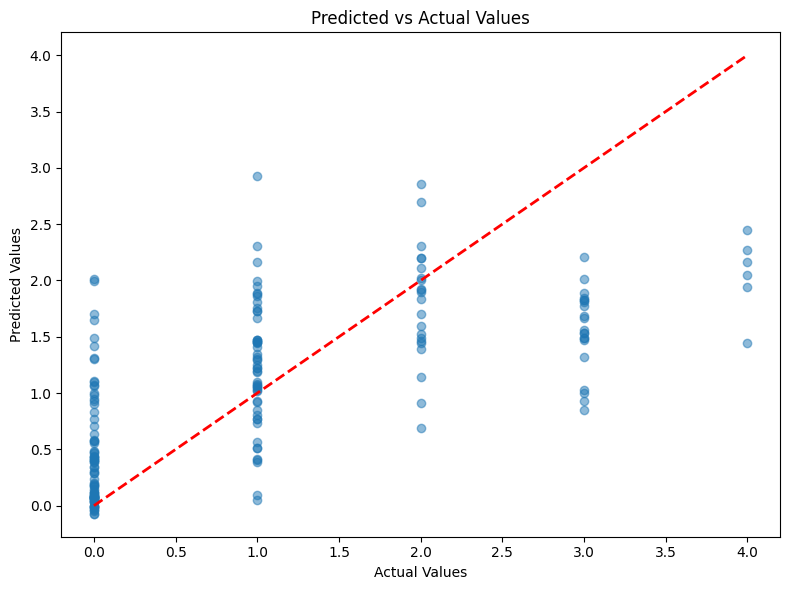

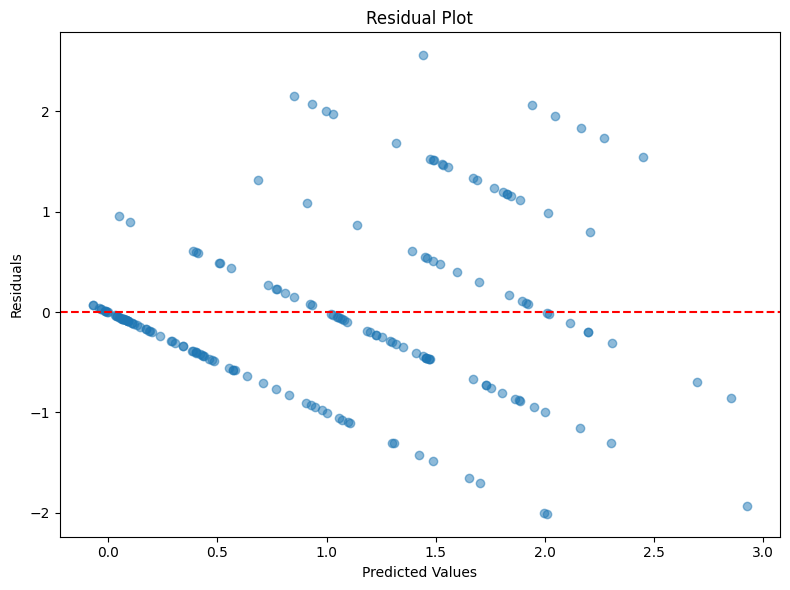

In [12]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}

    def fit(self, X, y=None):
        # Convert all columns to string type to avoid type comparison issues
        X = X.astype(str)
        # Handle missing values and encode categorical columns
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].fillna(X[col].mode()[0]))
            self.encoders[col] = le
        return self

    def transform(self, X):
        X = X.copy()
        # Convert all columns to string type to avoid type comparison issues
        X = X.astype(str)
        # Handle missing values in numeric columns
        numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
        for col in numeric_cols:
            X[col] = X[col].fillna(X[col].median())

        # Encode categorical columns
        for col, le in self.encoders.items():
            # Fit the encoder with all possible labels including those in the test set
            all_labels = np.unique(X[col].fillna(X[col].mode()[0]))
            le.classes_ = np.unique(np.concatenate((le.classes_, all_labels), axis=None))
            X[col] = le.transform(X[col].fillna(X[col].mode()[0]))
        return X


# Split the data into features and target
X = df.drop('label', axis=1).drop('id', axis=1)
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Print train/test set sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


# Define the search space for hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

def objective(params):
    pipeline = Pipeline([
        ('selector', DataFrameSelector(df.columns.drop('label').drop('id'))),
        ('preprocessor', DataPreprocessor()),
        ('regressor', xgb.XGBRegressor(
            use_label_encoder=False,
            eval_metric='mlogloss',
            **params
        ))
    ])
    
    # Use cross validation to evaluate the model
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # Return the negative mean score (hyperopt minimizes)
    return {'loss': -score.mean(), 'status': STATUS_OK}

space = {
    'max_depth': hp.choice('max_depth', range(3, 11)),
    'min_child_weight': hp.uniform('min_child_weight', 0.5, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

# Create and fit the final pipeline with best parameters
best_params = {
    'max_depth': best['max_depth'] + 3,  # Adjust for hp.choice offset
    'min_child_weight': best['min_child_weight'],
    'learning_rate': best['learning_rate'],
    'n_estimators': [100, 200, 300, 400, 500][best['n_estimators']],  # Adjust for hp.choice
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree']
}

pipeline = Pipeline([
    ('selector', DataFrameSelector(df.columns.drop('label').drop('id'))),
    ('preprocessor', DataPreprocessor()),
    ('regressor', xgb.XGBRegressor(
        use_label_encoder=False,
        eval_metric='mlogloss',
        **best_params
    ))
])

# Fit the pipeline with best parameters
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
# clip the values in label to be between 0 and 4
y_test = y_test.clip(0, 4)

# Calculate and print evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nRegression Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Create scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.tight_layout()
plt.show()

# Create residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()



In [13]:
import mlflow
import shutil

# Reset indices of X_train and y_train
X_train = X_train.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)

# Sample 100 rows from X_train and y_train
X_train_sample = X_train.sample(n=100, random_state=42)
y_train_sample = y_train[X_train_sample.index]

# Remove the existing 'best_model' directory if it exists
shutil.rmtree('best_model', ignore_errors=True)

# Infer the signature of the model based on the sample data
signature = mlflow.models.signature.infer_signature(X_train_sample, y_train_sample)

# Save the trained model to the 'best_model' directory with the inferred signature
mlflow.sklearn.save_model(pipeline, 'best_model', signature=signature, input_example=X_test)

In [14]:
test_df = pd.DataFrame(X_test)
test_df['label'] = y_test
test_df.to_csv('data/test_df.csv', index=False)